In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, HTML
InteractiveShell.ast_node_interactivity = "all"

import sys
import pickle
import glob



import os 
import pandas as pd 
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import random
import numpy as np
import wfdb
from collections import OrderedDict
from datetime import datetime 
import pickle 
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import metrics, tree, preprocessing, linear_model
from sklearn.metrics import roc_curve, auc, precision_recall_curve

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
# import shap

# shap.initjs()

c:\python3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data = pd.read_csv("Data/ct_report_dmg_thoracic_only_unsupervised_CLEAN.txt", sep=',', header=None)
data = data.rename(columns={0 : "index", 1 : "text"})
# data.head()

In [3]:
count_nan = len(data) - data.count()
count_nan

index     0
text     13
dtype: int64

In [4]:
data= data.dropna()
vectorizer = TfidfVectorizer(min_df=10)
model_tfidf = vectorizer.fit(data["text"])

In [5]:
X = model_tfidf.transform(data["text"])
import pickle
filename = 'Model/tfidf.sav'
pickle.dump(model_tfidf, open(filename, 'wb'))

In [6]:
def plot_ROC_CV(fpr,tpr, algo_name, ttl, CV):
    
    colors = ['cyan', 'indigo', 'darkgreen', 'blue', 'darkorange', 
                    'red', 'pink', 'black', 'yellow','magenta', 
                    'orange', 'lightseagreen']
    lw = 1
    lw2 = 3
        
    for i in range(len(fpr)):
        #area
        roc_auc = auc(fpr[i], tpr[i])

        if CV == True:

            plt.plot(fpr[i], tpr[i], lw=lw2, color=colors[i],
                     label= algo_name +' CV'+str(i) + ' (AUC=%0.3f)' % (roc_auc))
        else:
            plt.plot(fpr[i], tpr[i], lw=lw2, color=colors[i],
                     label= algo_name +' filename'+str(i) + ' (AUC=%0.3f)' % (roc_auc))


    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='grey') #label='Luck')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title(ttl)
    plt.legend(loc="lower right")
    fig = plt.figure() 
    plt.show()


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def Plot_PR_Curve(p, r, optCut_PR, optCut_P, optCut_R):
    fig = plt.figure()
    plt.plot(r,p, color='blue')
    plt.axhline(optCut_P, linestyle='--', color='black', label=  'threshold selected')
    plt.axvline(optCut_R, linestyle='--', color='black', label=  'threshold selected')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR curve')
    plt.show()

    
def opt_cutoff_PR(y, y_predict_proba):
    
    p,r,t = precision_recall_curve(y, y_predict_proba)

    diff = np.abs(p-r)
    min_diff = min(diff)
    i = np.where(diff==min_diff)
    i = i[0][0]
    optCut_PR = t[i]
    optCut_P = p[i]
    optCut_R = r[i]
    
    
    return p, r, optCut_PR, optCut_P, optCut_R


def GetModel(tuned_parameters, _scoring, cv_inner):

    clf = {}
    clf["RandomForest"] = GridSearchCV(RandomForestClassifier(), tuned_parameters["RandomForest"], cv= cv_inner, scoring= _scoring)
    clf["AdaBoost"] = GridSearchCV(AdaBoostClassifier(), tuned_parameters["AdaBoost"], cv= cv_inner, scoring= _scoring)
    clf["LogisticClassifier"] = GridSearchCV(linear_model.LogisticRegression(), tuned_parameters["LogisticClassifier"], cv= cv_inner, scoring= _scoring)
    clf["GradientBoosting"] = GridSearchCV(GradientBoostingClassifier(), tuned_parameters["GradientBoosting"], cv= cv_inner, scoring= _scoring)
    clf["xgboost"] = GridSearchCV(XGBClassifier(n_estimators = 500, learning_rate = 0.1, max_depth = 2, min_child_weight = 2, gamma = 0), tuned_parameters["xgboost"], cv= cv_inner, scoring= _scoring)
    return clf


def getprediction(prediction, cutoff):
    for i, pred in enumerate(prediction):
        if pred <= cutoff:
            prediction[i] = 0
        else:
            prediction[i] = 1
    return prediction


def getResults(clf, X_test, y_test, clf_name, label_1, label_2):
    print("Grid Search Results : ")
    print(clf.cv_results_, clf.best_params_, clf.best_score_)
    y_test_pred = clf.best_estimator_.predict_proba(X_test)[:,1]
    p, r, optCut_PR, optCut_P, optCut_R = opt_cutoff_PR(y_test, y_test_pred)
    prediction = getprediction(y_test_pred.copy(), optCut_PR)
    
#     print("/............................................Confusion Matrix Non_Normalized......................................./")
    cnf_matrix = confusion_matrix(y_test, prediction)
    
#     print("/............................................Confusion Matrix Normalized.........................................../")
    cnf_matrix_n = confusion_matrix(y_test, prediction)
    
    
    # ..................................................Table Paramters.........................................................
    col_d_eval = ['roc_auc_test', 
                   'TP', 'FN', 'TN', 'FP', 
                  'Accuracy', 'Sensitivity / Recall', 'Specificity', 'Precision', 'F1_score']
    _eval = {_key : np.nan for _key in col_d_eval}
    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test,  y_test_pred)
    _eval['roc_auc_test'] = auc(fpr_test, tpr_test)
    cnf_matrix = metrics.confusion_matrix(y_true=y_test, y_pred= prediction)
    _eval['TP'], _eval['FN'], _eval['TN'], _eval['FP']  = cnf_matrix[1][1], cnf_matrix[1][0], cnf_matrix[0][0], cnf_matrix[0][1]
    _eval['Accuracy'] = (_eval['TP']+_eval['TN'])/(_eval['TP']+_eval['TN']+_eval['FP']+_eval['FN'])
    _eval['Sensitivity / Recall'] = _eval['TP']/(_eval['TP']+_eval['FN'])
    _eval['Specificity'] = _eval['TN']/(_eval['TN']+_eval['FP'])
    _eval['Precision'] = _eval['TP']/(_eval['TP']+_eval['FP'])
    _eval['F1_score'] = 2 * (_eval['Precision'] * _eval['Sensitivity / Recall']) / (_eval['Precision'] + _eval['Sensitivity / Recall'])
    
    
    # ..................................................Feature Importance......................................................
    
    report = {}
    report["PR_Curve"] = [p, r, optCut_PR, optCut_P, optCut_R]
    report["estparam"] = clf.best_estimator_.get_params()
    report["classification_report"] = classification_report(y_test, prediction, target_names = [label_1, label_2])
    report["table_data"] = pd.DataFrame([_eval])
    report["confusion_matrix_non_normalized"] = cnf_matrix 
    report["confusion_matrix_normalized"] = cnf_matrix_n
    report["fpr_test"] = fpr_test
    report["tpr_test"] = tpr_test
    
    
    return report
    
def GetROC(lst_fpr, lst_tpr, clf_name, CV):
    fig = plt.figure()
    plot_ROC_CV(lst_fpr,lst_tpr, clf_name, 'Test', CV)
    plt.show()

def DisplayResults(report_lst, clf_name, params, PR_Curve, ClassificationReport, Confusion_Matrix, Confusion_Matrix_N, Table_data, ROC_curve, label_1, label_2):
    
    if params:
        print(" /...................................................","Display Paramters" "................................../")
        for i, CV in enumerate(report_lst):
            print(" /...................................................CV : ", i + 1, "................................../")
            display(CV["estparam"])
    
    if PR_Curve:
        print(" /...................................................","P-R Curve" "................................../")
        for i, CV in enumerate(report_lst):
            print(" /...................................................CV : ", i + 1, "................................../")
            Plot_PR_Curve(CV["PR_Curve"][0], CV["PR_Curve"][1], CV["PR_Curve"][2], CV["PR_Curve"][3], CV["PR_Curve"][4])
    
    if ClassificationReport:
        print(" /...................................................","classification_report" "................................../")
    
        for i, CV in enumerate(report_lst):
            print(" /...................................................CV : ", i + 1, "................................../")
            print(CV["classification_report"])
    
    if Confusion_Matrix:
        print(" /...................................................","confusion_matrix_non_normalized" "................................../")
    
        for i, CV in enumerate(report_lst):
            print(" /...................................................CV : ", i + 1, "................................../")
            class_names = [label_1, label_2]
            plot_confusion_matrix(CV["confusion_matrix_non_normalized"], classes=class_names, title='Confusion matrix')
    
    if Confusion_Matrix_N:
        print(" /...................................................","confusion_matrix_normalized" "................................../")
    
        for i, CV in enumerate(report_lst):
            print(" /...................................................CV : ", i + 1, "................................../")
            class_names = [label_1, label_2]
            plot_confusion_matrix(CV["confusion_matrix_normalized"], classes=class_names, title='Confusion matrix', normalize=True)
    
    if ROC_curve:
        print(" /...................................................","ROC Curve" "................................../")
    
        lst_fpr, lst_tpr = [], []
        for i, CV in enumerate(report_lst):
            lst_fpr.append(CV["fpr_test"])
            lst_tpr.append(CV["tpr_test"])
    
        GetROC(lst_fpr, lst_tpr, clf_name, CV = True)
        
    if Table_data:
        print(" /...................................................","table_data" "................................../")
    
        pd_lst = []
        for i, CV in enumerate(report_lst):
            pd_lst.append(CV["table_data"])
        df_eval = pd.concat(pd_lst, ignore_index=True)
        print(df_eval.head(100))
        print(" /...................................................","Mean and variance of Table Data" "................................../")
        print(df_eval.describe())


In [10]:
### lets train a model based on tfidf

data_train = pd.read_csv("Data/ct_report_dmg_thoracic_only_LDAtrain_CHECKED.csv", sep=',', header=None, encoding='latin1')

data_train = data_train[[1, 8]]

data_train = data_train.rename(columns={8 : "labels", 1 : "text"})

data_train= data_train.dropna()

data_train['label_num'] = data_train.labels.map({'NC':0, 'C':1})

# data_train.head()


labels = data_train[["label_num"]]

Features = data_train.drop('labels', 1)

Features = Features.drop('label_num', 1)

# Features.head()

X_train_Data, X_test_Data, y_train, y_test = train_test_split(Features, labels, test_size = 0.1, random_state = 10)

## Topic Modelling Classifier

X_train = X_train_Data["text"]
X_test = X_test_Data["text"]

X_train = model_tfidf.transform(X_train)
X_test = model_tfidf.transform(X_test)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=2, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [2]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='neg_log_loss',
       verbose=0)

Grid Search Results : 
{'mean_fit_time': array([3.00618165]), 'std_fit_time': array([0.10748394]), 'mean_score_time': array([0.00375051]), 'std_score_time': array([0.00025001]), 'param_max_depth': masked_array(data=[2],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 2}], 'split0_test_score': array([-0.26755575]), 'split1_test_score': array([-0.24518952]), 'split2_test_score': array([-0.18396127]), 'split3_test_score': array([-0.26734587]), 'split4_test_score': array([-0.26084059]), 'split5_test_score': array([-0.11112485]), 'split6_test_score': array([-0.16694981]), 'split7_test_score': array([-0.39920656]), 'split8_test_score': array([-0.11671728]), 'split9_test_score': array([-0.14593021]), 'mean_test_score': array([-0.21673263]), 'std_test_score': array([0.08373032]), 'rank_test_score': array([1]), 'split0_train_score': array([-0.01306428]), 'split1_train_score': array([-0.01336484]), 'split2_train_score': array([-0.0138979]), '

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 2,
 'missing': None,
 'n_estimators': 500,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

 /................................................... P-R Curve................................../
 /...................................................CV :  1 ................................../


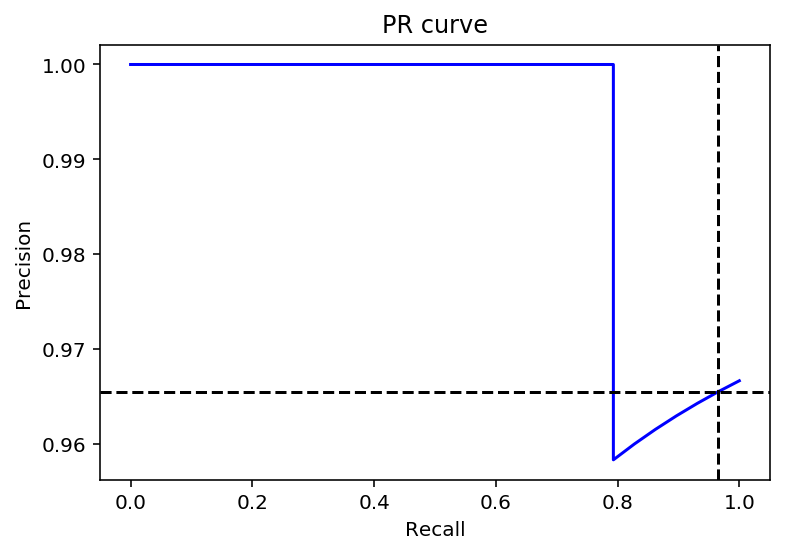

 /................................................... classification_report................................../
 /...................................................CV :  1 ................................../
             precision    recall  f1-score   support

 non_Cancer       0.94      0.97      0.95        31
     cancer       0.96      0.93      0.95        29

avg / total       0.95      0.95      0.95        60

 /................................................... confusion_matrix_non_normalized................................../
 /...................................................CV :  1 ................................../
Confusion matrix, without normalization
[[30  1]
 [ 2 27]]


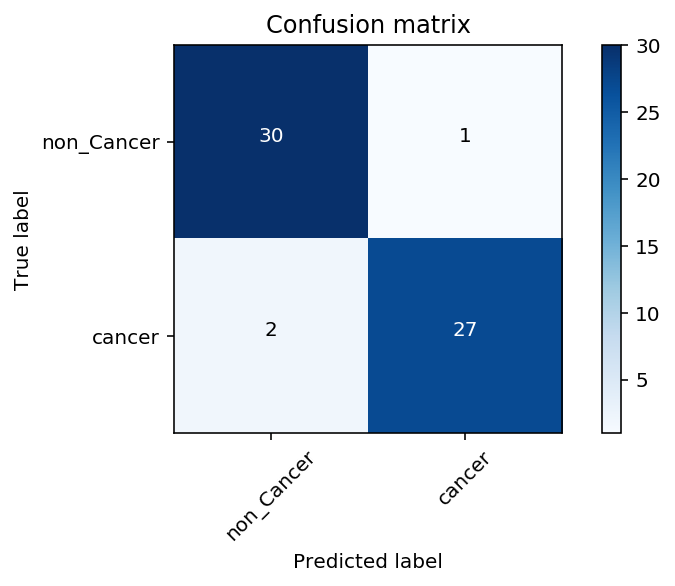

 /................................................... confusion_matrix_normalized................................../
 /...................................................CV :  1 ................................../
Normalized confusion matrix
[[0.96774194 0.03225806]
 [0.06896552 0.93103448]]


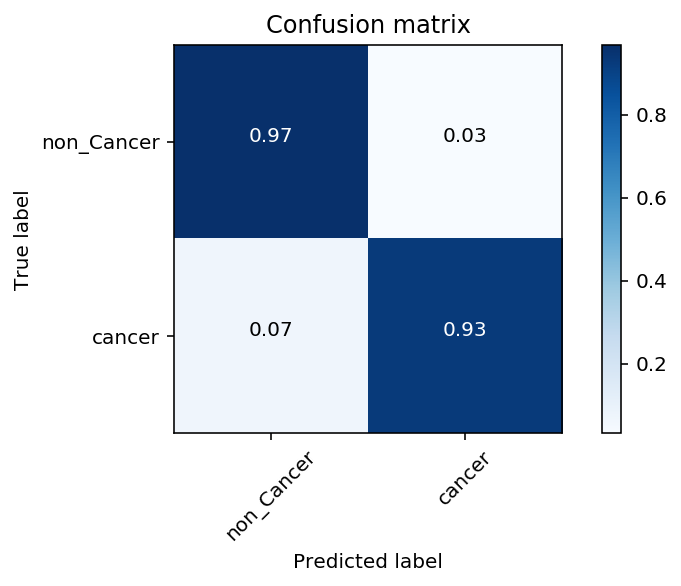

 /................................................... ROC Curve................................../


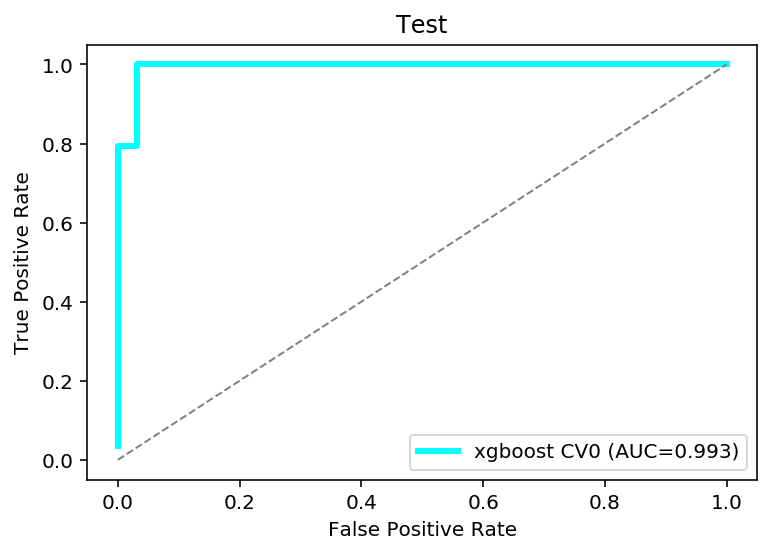

<Figure size 432x288 with 0 Axes>

 /................................................... table_data................................../
   Accuracy  F1_score  FN  FP  Precision  Sensitivity / Recall  Specificity  TN  TP  roc_auc_test
0      0.95  0.947368   2   1   0.964286              0.931034     0.967742  30  27      0.993326
 /................................................... Mean and variance of Table Data................................../
       Accuracy  F1_score   FN   FP  Precision  Sensitivity / Recall  Specificity    TN    TP  roc_auc_test
count      1.00  1.000000  1.0  1.0   1.000000              1.000000     1.000000   1.0   1.0      1.000000
mean       0.95  0.947368  2.0  1.0   0.964286              0.931034     0.967742  30.0  27.0      0.993326
std         NaN       NaN  NaN  NaN        NaN                   NaN          NaN   NaN   NaN           NaN
min        0.95  0.947368  2.0  1.0   0.964286              0.931034     0.967742  30.0  27.0      0.993326
25%        0.95  0.947368  2.0  1.0   0.964

In [11]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

#-------- Set cross-validation splits  --------
#Inner loop

# Moving from 5 fold cross validation to 10 fold, 5 fold was kept to reduce time during grid search, now we have the ideal hyperparaters
# we can apply 10 fold cross validation

n_cv_splits_inner = 10
cv_inner = StratifiedKFold(n_splits= n_cv_splits_inner, random_state=42)

clf_name = "xgboost"

_scoring = 'neg_log_loss'

label_2, label_1 = "cancer", "non_Cancer"

tuned_parameters = {}
tuned_parameters["RandomForest"]  = [{'n_estimators': [500]}, {'class_weight': [None, "balanced", "balanced_subsample"]}, {'max_depth': [None, 5, 10, 20, 50]}]
tuned_parameters["AdaBoost"]  = [{'n_estimators': [500]}, {'learning_rate': [0.1, 0.3, 0.5, 0.8, 1.0]}, {'algorithm': ["SAMME", "SAMME.R"]}]
tuned_parameters["LogisticClassifier"]  = [{'C': [0.1, 0.3, 0.5, 0.7, 1.0]}, {'penalty': ['l1', 'l2']}, {'class_weight': [None, 'balanced']}]
tuned_parameters["GradientBoosting"]  = [{'n_estimators': [500]}, {'learning_rate': [0.1, 0.3, 0.5, 0.8, 1.0]}, {'loss': ['deviance', 'exponential']}]
tuned_parameters["xgboost"]  = [{'max_depth': [2]}]


# Display the following (one can disable it by making it false)
params = True 
PR_Curve = True
ClassificationReport = True
Confusion_Matrix = True
Confusion_Matrix_N = True
Table_data = True
ROC_curve = True



clf={}
clf = GetModel(tuned_parameters, _scoring, cv_inner)
clf[clf_name].fit(X_train, y_train)

X = model_tfidf.transform(data["text"])
import pickle
filename = 'Model/clf_NC_C_tfidf.sav'
pickle.dump(clf[clf_name], open(filename, 'wb'))

report_lst = []
report_lst.append(getResults(clf[clf_name], X_test, y_test, clf_name, label_1, label_2))
DisplayResults(report_lst, clf_name, params, PR_Curve, ClassificationReport, Confusion_Matrix, Confusion_Matrix_N, Table_data, ROC_curve, label_1, label_2)

In [15]:
### lets train a model based on tfidf

data_train = pd.read_csv("Data/ct_report_dmg_thoracic_only_LDAtrain_CHECKED.csv", sep=',', header=None, encoding='latin1')

data_train = data_train[[1, 9]]

data_train = data_train.rename(columns={9 : "labels", 1 : "text"})

data_train= data_train.dropna()

data_train['label_num'] = data_train.labels.map({'NP':0, 'P':1})

# data_train.head()


labels = data_train[["label_num"]]

Features = data_train.drop('labels', 1)

Features = Features.drop('label_num', 1)

# Features.head()

X_train_Data, X_test_Data, y_train, y_test = train_test_split(Features, labels, test_size = 0.1, random_state = 10)

## Topic Modelling Classifier

X_train = X_train_Data["text"]
X_test = X_test_Data["text"]

X_train = model_tfidf.transform(X_train)
X_test = model_tfidf.transform(X_test)
# print('Saving vectors...')

# filename = 'Model/Doc2Vec.sav'
# ModelDoc2Vec = pickle.load(open(filename, 'rb'))

# X_train = X_train.apply(lambda text: ModelDoc2Vec.infer_vector(text.split()))
# X_test = X_test.apply(lambda text: ModelDoc2Vec.infer_vector(text.split()))
# X_train = pd.DataFrame(X_train.values.tolist()).add_prefix('code_').values
# X_test = pd.DataFrame(X_test.values.tolist()).add_prefix('code_').values

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=2, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [2]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='neg_log_loss',
       verbose=0)

Grid Search Results : 
{'mean_fit_time': array([3.26686482]), 'std_fit_time': array([0.03197862]), 'mean_score_time': array([0.00370049]), 'std_score_time': array([0.00024489]), 'param_max_depth': masked_array(data=[2],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 2}], 'split0_test_score': array([-0.69964235]), 'split1_test_score': array([-0.47376746]), 'split2_test_score': array([-0.4537641]), 'split3_test_score': array([-0.42779541]), 'split4_test_score': array([-0.48508065]), 'split5_test_score': array([-0.47739046]), 'split6_test_score': array([-0.66655052]), 'split7_test_score': array([-0.60572747]), 'split8_test_score': array([-0.45015096]), 'split9_test_score': array([-0.59348314]), 'mean_test_score': array([-0.53286627]), 'std_test_score': array([0.09376717]), 'rank_test_score': array([1]), 'split0_train_score': array([-0.02786554]), 'split1_train_score': array([-0.03144812]), 'split2_train_score': array([-0.02997382]), '

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 2,
 'missing': None,
 'n_estimators': 500,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

 /................................................... P-R Curve................................../
 /...................................................CV :  1 ................................../


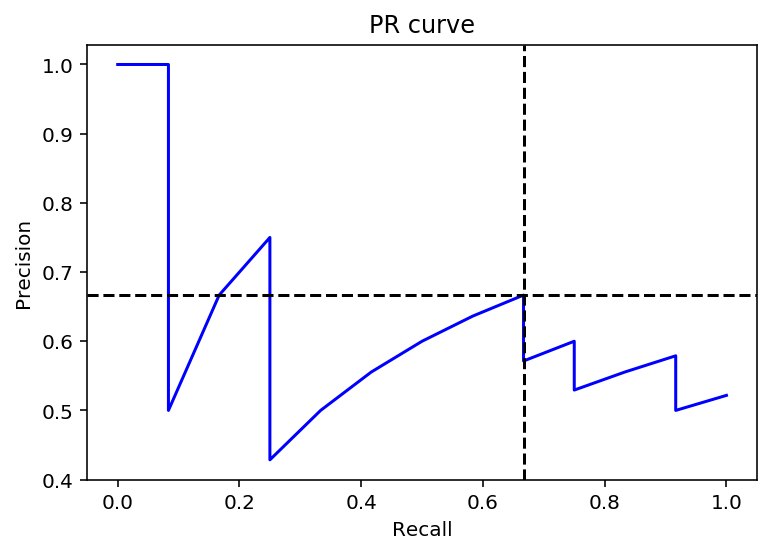

 /................................................... classification_report................................../
 /...................................................CV :  1 ................................../
                 precision    recall  f1-score   support

non_Progression       0.90      0.92      0.91        48
    Progression       0.64      0.58      0.61        12

    avg / total       0.85      0.85      0.85        60

 /................................................... confusion_matrix_non_normalized................................../
 /...................................................CV :  1 ................................../
Confusion matrix, without normalization
[[44  4]
 [ 5  7]]


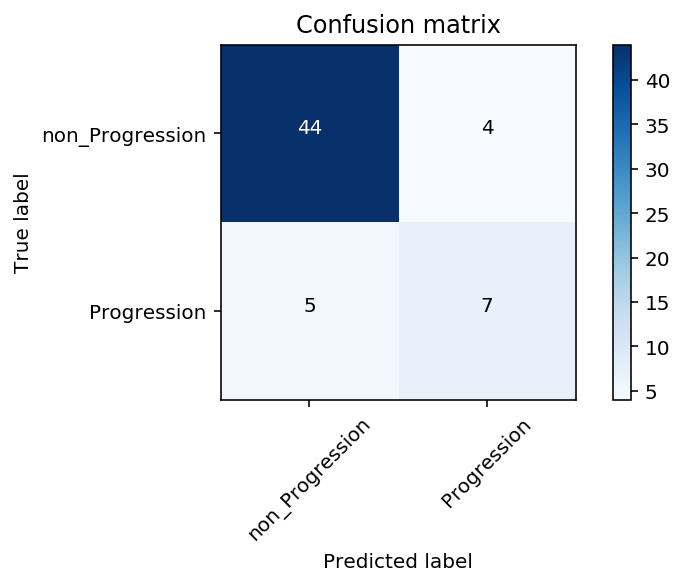

 /................................................... confusion_matrix_normalized................................../
 /...................................................CV :  1 ................................../
Normalized confusion matrix
[[0.91666667 0.08333333]
 [0.41666667 0.58333333]]


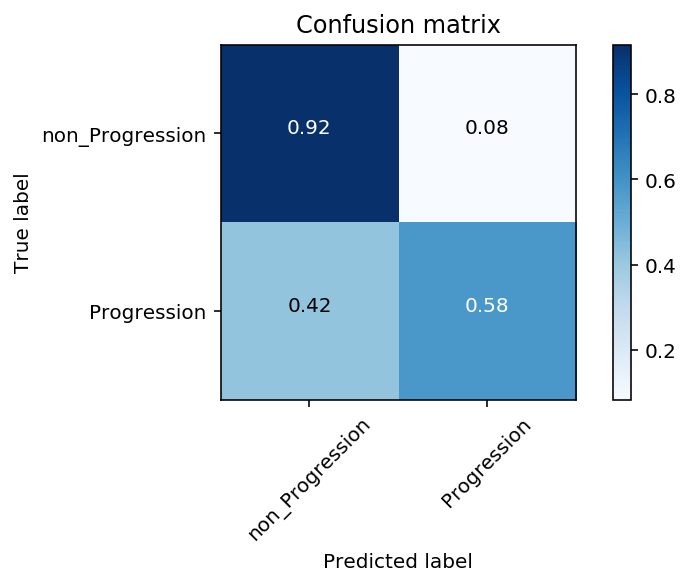

 /................................................... ROC Curve................................../


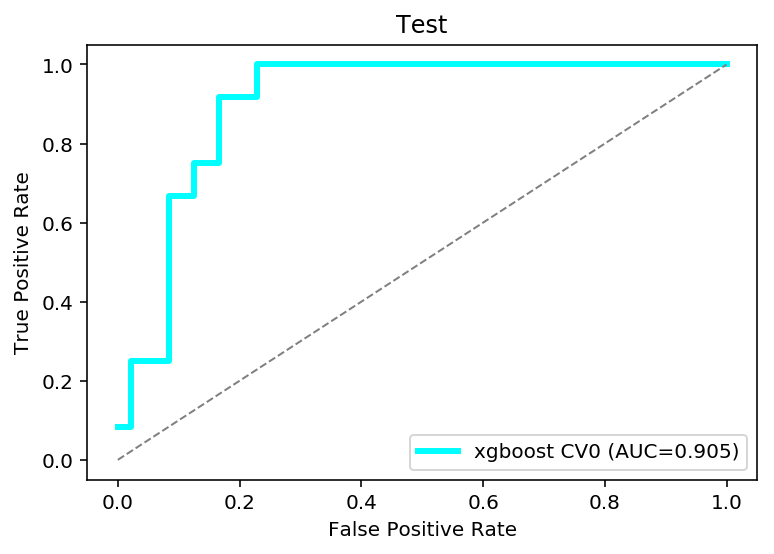

<Figure size 432x288 with 0 Axes>

 /................................................... table_data................................../
   Accuracy  F1_score  FN  FP  Precision  Sensitivity / Recall  Specificity  TN  TP  roc_auc_test
0      0.85  0.608696   5   4   0.636364              0.583333     0.916667  44   7      0.904514
 /................................................... Mean and variance of Table Data................................../
       Accuracy  F1_score   FN   FP  Precision  Sensitivity / Recall  Specificity    TN   TP  roc_auc_test
count      1.00  1.000000  1.0  1.0   1.000000              1.000000     1.000000   1.0  1.0      1.000000
mean       0.85  0.608696  5.0  4.0   0.636364              0.583333     0.916667  44.0  7.0      0.904514
std         NaN       NaN  NaN  NaN        NaN                   NaN          NaN   NaN  NaN           NaN
min        0.85  0.608696  5.0  4.0   0.636364              0.583333     0.916667  44.0  7.0      0.904514
25%        0.85  0.608696  5.0  4.0   0.636364  

In [16]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

#-------- Set cross-validation splits  --------
#Inner loop

# Moving from 5 fold cross validation to 10 fold, 5 fold was kept to reduce time during grid search, now we have the ideal hyperparaters
# we can apply 10 fold cross validation

n_cv_splits_inner = 10
cv_inner = StratifiedKFold(n_splits= n_cv_splits_inner, random_state=42)

clf_name = "xgboost"

_scoring = 'neg_log_loss'

label_2, label_1 = "Progression", "non_Progression"

tuned_parameters = {}
tuned_parameters["RandomForest"]  = [{'n_estimators': [500]}, {'class_weight': [None, "balanced", "balanced_subsample"]}, {'max_depth': [None, 5, 10, 20, 50]}]
tuned_parameters["AdaBoost"]  = [{'n_estimators': [500]}, {'learning_rate': [0.1, 0.3, 0.5, 0.8, 1.0]}, {'algorithm': ["SAMME", "SAMME.R"]}]
tuned_parameters["LogisticClassifier"]  = [{'C': [0.1, 0.3, 0.5, 0.7, 1.0]}, {'penalty': ['l1', 'l2']}, {'class_weight': [None, 'balanced']}]
tuned_parameters["GradientBoosting"]  = [{'n_estimators': [500]}, {'learning_rate': [0.1, 0.3, 0.5, 0.8, 1.0]}, {'loss': ['deviance', 'exponential']}]
tuned_parameters["xgboost"]  = [{'max_depth': [2]}]


# Display the following (one can disable it by making it false)
params = True 
PR_Curve = True
ClassificationReport = True
Confusion_Matrix = True
Confusion_Matrix_N = True
Table_data = True
ROC_curve = True



clf={}
clf = GetModel(tuned_parameters, _scoring, cv_inner)
clf[clf_name].fit(X_train, y_train)

filename = 'Model/clf_NP_P_tfidf.sav'
pickle.dump(clf[clf_name], open(filename, 'wb'))

report_lst = []
report_lst.append(getResults(clf[clf_name], X_test, y_test, clf_name, label_1, label_2))
DisplayResults(report_lst, clf_name, params, PR_Curve, ClassificationReport, Confusion_Matrix, Confusion_Matrix_N, Table_data, ROC_curve, label_1, label_2)

In [17]:
### lets train a model based on Doc2Vec

data_train = pd.read_csv("Data/ct_report_dmg_thoracic_only_LDAtrain_CHECKED.csv", sep=',', header=None, encoding='latin1')

data_train = data_train[[1, 9]]

data_train = data_train.rename(columns={9 : "labels", 1 : "text"})

data_train= data_train.dropna()

data_train['label_num'] = data_train.labels.map({'NP':0, 'P':1})

# data_train.head()


labels = data_train[["label_num"]]

Features = data_train.drop('labels', 1)

Features = Features.drop('label_num', 1)

# Features.head()

X_train_Data, X_test_Data, y_train, y_test = train_test_split(Features, labels, test_size = 0.1, random_state = 10)

## Topic Modelling Classifier

X_train = X_train_Data["text"]
X_test = X_test_Data["text"]

# X_train = model_tfidf.transform(X_train)
# X_test = model_tfidf.transform(X_test)
# print('Saving vectors...')

filename = 'Model/Doc2Vec.sav'
ModelDoc2Vec = pickle.load(open(filename, 'rb'))

X_train = X_train.apply(lambda text: ModelDoc2Vec.infer_vector(text.split()))
X_test = X_test.apply(lambda text: ModelDoc2Vec.infer_vector(text.split()))
X_train = pd.DataFrame(X_train.values.tolist()).add_prefix('code_').values
X_test = pd.DataFrame(X_test.values.tolist()).add_prefix('code_').values

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=2, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'max_depth': [2]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='neg_log_loss',
       verbose=0)

Grid Search Results : 
{'mean_fit_time': array([4.45986629]), 'std_fit_time': array([0.02123972]), 'mean_score_time': array([0.00225031]), 'std_score_time': array([0.00024998]), 'param_max_depth': masked_array(data=[2],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 2}], 'split0_test_score': array([-0.56231586]), 'split1_test_score': array([-0.55006214]), 'split2_test_score': array([-0.60877432]), 'split3_test_score': array([-0.59383685]), 'split4_test_score': array([-0.59466197]), 'split5_test_score': array([-0.52137743]), 'split6_test_score': array([-0.43432062]), 'split7_test_score': array([-0.59883182]), 'split8_test_score': array([-0.66029755]), 'split9_test_score': array([-0.39106745]), 'mean_test_score': array([-0.55211711]), 'std_test_score': array([0.07786358]), 'rank_test_score': array([1]), 'split0_train_score': array([-0.01368158]), 'split1_train_score': array([-0.01349921]), 'split2_train_score': array([-0.01340891]), 

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 2,
 'missing': None,
 'n_estimators': 500,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

 /................................................... P-R Curve................................../
 /...................................................CV :  1 ................................../


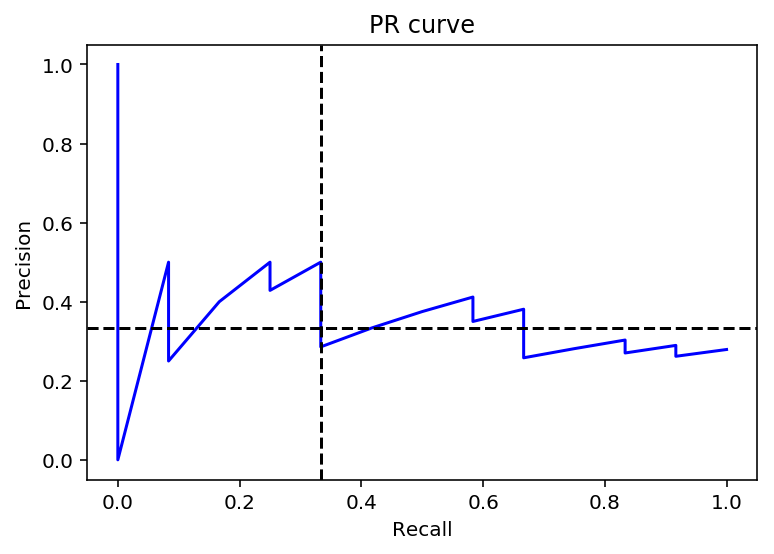

 /................................................... classification_report................................../
 /...................................................CV :  1 ................................../
                 precision    recall  f1-score   support

non_Progression       0.84      0.85      0.85        48
    Progression       0.36      0.33      0.35        12

    avg / total       0.74      0.75      0.75        60

 /................................................... confusion_matrix_non_normalized................................../
 /...................................................CV :  1 ................................../
Confusion matrix, without normalization
[[41  7]
 [ 8  4]]


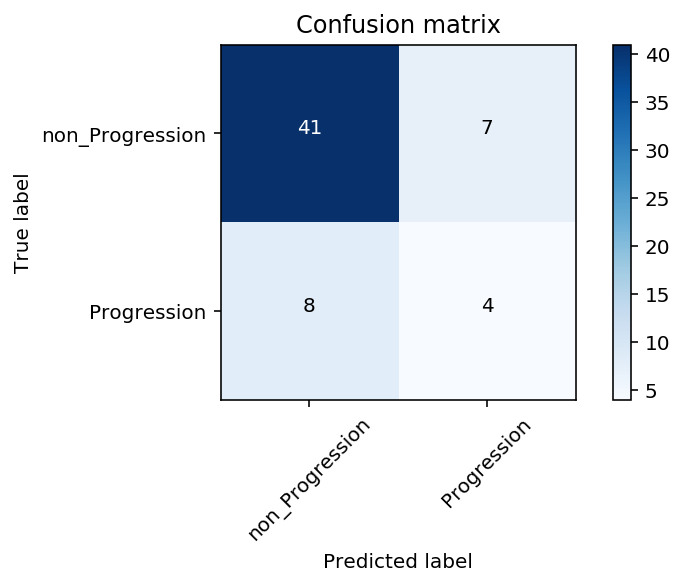

 /................................................... confusion_matrix_normalized................................../
 /...................................................CV :  1 ................................../
Normalized confusion matrix
[[0.85416667 0.14583333]
 [0.66666667 0.33333333]]


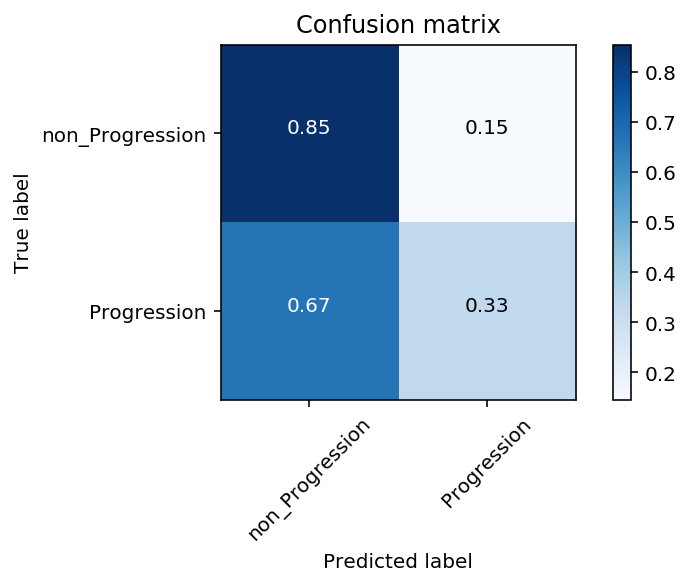

 /................................................... ROC Curve................................../


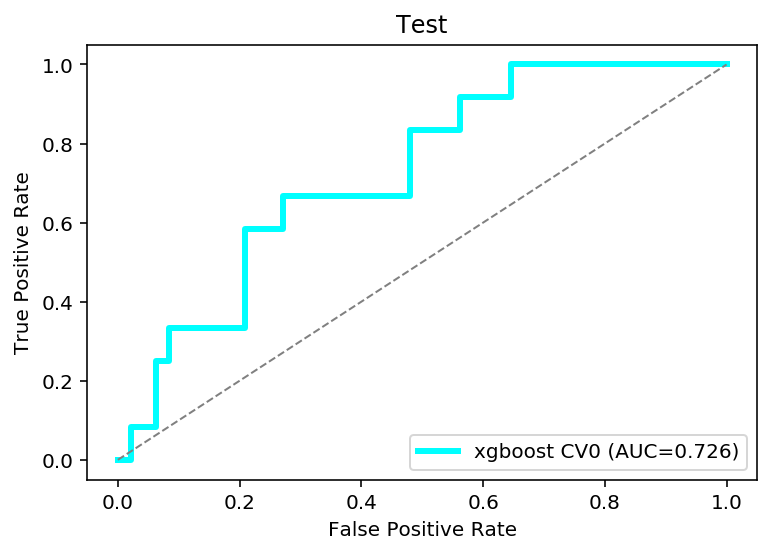

<Figure size 432x288 with 0 Axes>

 /................................................... table_data................................../
   Accuracy  F1_score  FN  FP  Precision  Sensitivity / Recall  Specificity  TN  TP  roc_auc_test
0      0.75  0.347826   8   7   0.363636              0.333333     0.854167  41   4      0.725694
 /................................................... Mean and variance of Table Data................................../
       Accuracy  F1_score   FN   FP  Precision  Sensitivity / Recall  Specificity    TN   TP  roc_auc_test
count      1.00  1.000000  1.0  1.0   1.000000              1.000000     1.000000   1.0  1.0      1.000000
mean       0.75  0.347826  8.0  7.0   0.363636              0.333333     0.854167  41.0  4.0      0.725694
std         NaN       NaN  NaN  NaN        NaN                   NaN          NaN   NaN  NaN           NaN
min        0.75  0.347826  8.0  7.0   0.363636              0.333333     0.854167  41.0  4.0      0.725694
25%        0.75  0.347826  8.0  7.0   0.363636  

In [18]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

#-------- Set cross-validation splits  --------
#Inner loop

# Moving from 5 fold cross validation to 10 fold, 5 fold was kept to reduce time during grid search, now we have the ideal hyperparaters
# we can apply 10 fold cross validation

n_cv_splits_inner = 10
cv_inner = StratifiedKFold(n_splits= n_cv_splits_inner, random_state=42)

clf_name = "xgboost"

_scoring = 'neg_log_loss'

label_2, label_1 = "Progression", "non_Progression"

tuned_parameters = {}
tuned_parameters["RandomForest"]  = [{'n_estimators': [500]}, {'class_weight': [None, "balanced", "balanced_subsample"]}, {'max_depth': [None, 5, 10, 20, 50]}]
tuned_parameters["AdaBoost"]  = [{'n_estimators': [500]}, {'learning_rate': [0.1, 0.3, 0.5, 0.8, 1.0]}, {'algorithm': ["SAMME", "SAMME.R"]}]
tuned_parameters["LogisticClassifier"]  = [{'C': [0.1, 0.3, 0.5, 0.7, 1.0]}, {'penalty': ['l1', 'l2']}, {'class_weight': [None, 'balanced']}]
tuned_parameters["GradientBoosting"]  = [{'n_estimators': [500]}, {'learning_rate': [0.1, 0.3, 0.5, 0.8, 1.0]}, {'loss': ['deviance', 'exponential']}]
tuned_parameters["xgboost"]  = [{'max_depth': [2]}]


# Display the following (one can disable it by making it false)
params = True 
PR_Curve = True
ClassificationReport = True
Confusion_Matrix = True
Confusion_Matrix_N = True
Table_data = True
ROC_curve = True



clf={}
clf = GetModel(tuned_parameters, _scoring, cv_inner)
clf[clf_name].fit(X_train, y_train)

filename = 'Model/clf_NP_P_Doc2Vec.sav'
pickle.dump(clf[clf_name], open(filename, 'wb'))

report_lst = []
report_lst.append(getResults(clf[clf_name], X_test, y_test, clf_name, label_1, label_2))
DisplayResults(report_lst, clf_name, params, PR_Curve, ClassificationReport, Confusion_Matrix, Confusion_Matrix_N, Table_data, ROC_curve, label_1, label_2)